## Step - 1 : Convert keras model to TF Frozen model file and its text representation

In [1]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2
import numpy as np


model = keras.models.load_model(
    "/Users/stephenmesser/Desktop/FS-AI/cone_colour_detection/cones_model5050_stri55.keras"
)

# Convert Keras model to ConcreteFunction
full_model = tf.function(lambda x: model(x))
full_model = full_model.get_concrete_function(
    x=tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype))

# Get frozen ConcreteFunction
frozen_func = convert_variables_to_constants_v2(full_model)
frozen_func.graph.as_graph_def()

# inspect the layers operations inside your frozen graph definition and see the name of its input and output tensors
layers = [op.name for op in frozen_func.graph.get_operations()]
print("-" * 50)
print("Frozen model layers: ")
for layer in layers:
    print(layer)

print("-" * 50)
print("Frozen model inputs: ")
print(frozen_func.inputs)
print("Frozen model outputs: ")
print(frozen_func.outputs)

# Save frozen graph from frozen ConcreteFunction to hard drive
# serialize the frozen graph and its text representation to disk.
tf.io.write_graph(graph_or_graph_def=frozen_func.graph,
                  logdir="./frozen_models",
                  name="simple_frozen_graph.pb",
                  as_text=False)

#Optional
tf.io.write_graph(graph_or_graph_def=frozen_func.graph,
                  logdir="./frozen_models",
                  name="simple_frozen_graph.pbtxt",
                as_text=True)

2023-04-19 23:04:49.901923: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-19 23:04:56.584274: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-19 23:04:56.755058: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2023-04-19 23:04:56.755193: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session


--------------------------------------------------
Frozen model layers: 
x
sequential_6/conv2d_6/Conv2D/ReadVariableOp/resource
sequential_6/conv2d_6/BiasAdd/ReadVariableOp/resource
sequential_6/flatten_6/Const
sequential_6/dense_11/MatMul/ReadVariableOp/resource
sequential_6/dense_11/BiasAdd/ReadVariableOp/resource
sequential_6/dense_12/MatMul/ReadVariableOp/resource
sequential_6/dense_12/BiasAdd/ReadVariableOp/resource
sequential_6/conv2d_6/Conv2D/ReadVariableOp
sequential_6/conv2d_6/Conv2D
sequential_6/conv2d_6/BiasAdd/ReadVariableOp
sequential_6/conv2d_6/BiasAdd
sequential_6/conv2d_6/Relu
sequential_6/max_pooling2d_6/MaxPool
sequential_6/dropout_6/Identity
sequential_6/flatten_6/Reshape
sequential_6/dense_11/MatMul/ReadVariableOp
sequential_6/dense_11/MatMul
sequential_6/dense_11/BiasAdd/ReadVariableOp
sequential_6/dense_11/BiasAdd
sequential_6/dense_11/Relu
sequential_6/dense_12/MatMul/ReadVariableOp
sequential_6/dense_12/MatMul
sequential_6/dense_12/BiasAdd/ReadVariableOp
sequent

'./frozen_models/simple_frozen_graph.pbtxt'

In [2]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 46, 46, 32)        2432      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 9, 9, 32)         0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 9, 9, 32)          0         
                                                                 
 flatten_6 (Flatten)         (None, 2592)              0         
                                                                 
 dense_11 (Dense)            (None, 128)               331904    
                                                                 
 dense_12 (Dense)            (None, 4)                 516       
                                                      

### List `frozen_models` directory, here you will find
- `simple_frozen_graph.pb`  - TF frozen graph model file
- `simple_frozen_graph.pbtxt` - TF frozen graph text representation

In [3]:
!ls -l frozen_models

total 9984
-rw-r--r--  1 stephenmesser  staff  1343004 Apr 19 23:04 simple_frozen_graph.pb
-rw-r--r--  1 stephenmesser  staff  3766060 Apr 19 23:04 simple_frozen_graph.pbtxt


## Step - 2 : Run inferencing using the frozen model

Tensor Input :  Tensor("x:0", shape=(None, None, None, 3), dtype=float32)
Tensor Output:  Tensor("Identity:0", shape=(None, None, None, 8), dtype=float32)
..... Extracing Number Plate .......


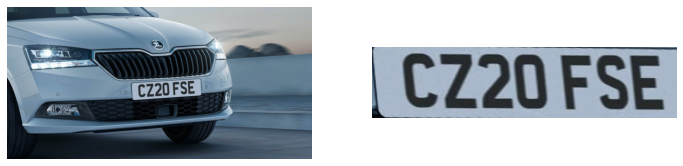

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import tensorflow.compat.v1 as tf
from local_utils import reconstruct

def preprocess_image(image_path,resize=False):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255
    if resize:
        img = cv2.resize(img, (224,224))
    return img

def get_plate(image_path, sess, Dmax=608, Dmin = 608):
    vehicle = preprocess_image(image_path)
    ratio = float(max(vehicle.shape[:2])) / min(vehicle.shape[:2])
    side = int(ratio * Dmin)
    bound_dim = min(side, Dmax)
    processed_image, Iresized = prepare_image_for_tf_inferencing(vehicle, bound_dim)
    infrencing = sess.run(output_tensor, {'x:0': processed_image})
    np_inferencing = np.squeeze(infrencing)
    _ , LpImg, _, cor = detect_lp_tf(Iresized, np_inferencing, vehicle, lp_threshold=0.5)
    return vehicle, LpImg, cor

def prepare_image_for_tf_inferencing(vehicle, bound_dim):
    min_dim_img = min(vehicle.shape[:2])
    factor = float(bound_dim) / min_dim_img
    w, h = (np.array(vehicle.shape[1::-1], dtype=float) * factor).astype(int).tolist()
    Iresized = cv2.resize(vehicle, (w, h))
    T = Iresized.copy()
    T = T.reshape((1, T.shape[0], T.shape[1], T.shape[2]))
    return T, Iresized

def detect_lp_tf(Iresized, np_inferencing, I, lp_threshold):
    L, TLp, lp_type, Cor = reconstruct(I, Iresized, np_inferencing, lp_threshold)
    return L, TLp, lp_type, Cor


## Loading model
sess=tf.InteractiveSession()
frozen_graph="./frozen_models/simple_frozen_graph.pb"
with tf.gfile.GFile(frozen_graph, "rb") as f:
      graph_def = tf.GraphDef()
      graph_def.ParseFromString(f.read())
sess.graph.as_default()
tf.import_graph_def(graph_def)
# Frozen model inputs: 
# [<tf.Tensor 'x:0' shape=(None, None, None, 3) dtype=float32>]
# Frozen model outputs: 
# [<tf.Tensor 'Identity:0' shape=(None, None, None, 8) dtype=float32>]  
input_tensor = sess.graph.get_tensor_by_name("x:0") 
output_tensor = sess.graph.get_tensor_by_name("Identity:0")        
print("Tensor Input : ", input_tensor)
print("Tensor Output: ", output_tensor)
print("..... Extracing Number Plate .......")

test_image_path = "dataset/plate5.jpeg"
vehicle, LpImg,cor = get_plate(test_image_path, sess)


fig = plt.figure(figsize=(12,6))
grid = gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
fig.add_subplot(grid[0])
plt.axis(False)
plt.imshow(vehicle)
grid = gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
fig.add_subplot(grid[1])
plt.axis(False)
plt.imshow(LpImg[0])

## Summary
- In this notebook, we have converted keras h5 model to tensorflow frozen model and its text representation
- We have validated that the newly created TF frozen graph model works